In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import eda
import random as random
from os.path import join as pjoin
import importlib
importlib.reload(eda)
from utils import utils
from sklearn.model_selection import cross_validate
#from utils import knn_validation
#from utils import knn_cross_validation
#from utils import nearest_prototypes

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
#smote_enn = SMOTEENN(random_state=0)
#X_resampled, y_resampled = smote_enn.fit_resample(X, y)


DATA_DIR = './data/'

In [4]:
def load_data():
    ## 0. To obtain reproducible results, we set the random seeds
    random.seed(2020)
    np.random.seed(2020)
    ## 1. Load training set

    dataset_file = pjoin(DATA_DIR, 'adult.data')
    testset_file = pjoin(DATA_DIR, 'adult.test')

    train = pd.read_csv(dataset_file, header=None, delimiter=r",\s+", engine='python')
    train.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
    ]
    #train_samples = train.drop(columns="Income")
    #train_labels = train.Income
    #train.info()
    
    test = pd.read_csv(testset_file, header=None, delimiter=r",\s+", engine='python')
    test.columns = [
        "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
        "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
        "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
    ]
    
    #test_samples = test.drop(columns="Income")
    #test_labels = test.Income
    
    return train, test

In [5]:
def data_preprocess(data,is_train):
    data = eda.NativeCountry_replace(data)
    data = eda.WorkClass_replace(data)
    data = eda.Occupation_replace(data)
    data = eda.Education_remove(data)
    data = eda.Capital_merge(data)
    #train_samples, train_labels, weight = get_X_y(train)#drop also weights
    data = eda.NativeCountry_classify(data)
    

    #without PCA
    data_samples = data.drop(columns="Income")
    
    data_labels = data.Income.map({"<=50K": 0, ">50K": 1})
    if is_train == False:
        data_labels = data.Income.map({"<=50K.": 0, ">50K.": 1})
        
    data_samples = eda.X_to_dummy(data_samples, None)
    print(data_samples.info())
    data_samples = data_samples.to_numpy()
    data_samples = eda.standardization(data_samples)

    
    """
    #with PCA
    
    data_samples, data_labels, weight = eda.get_X_y(data,is_train)
    #print(len(weight))
    data_samples = eda.X_to_dummy(data_samples, None)
    print(data_samples.info())
    data_samples = data_samples.to_numpy()
    #data_samples = eda.standardization(data_samples)
    data_samples, _ = eda.PCA_with_weight(data_samples,weight)    
    """
    return data_samples,data_labels

In [6]:
def preprocess(train,test):
    print("preprocessing training set")
    train_samples, train_labels = data_preprocess(train,True)
    
    print("preprocessing test set")
    test_samples, test_labels = data_preprocess(test,False)
    
    print("number of variables")
    print(len(train_samples[0]))
    print('done')
    return train_samples, train_labels, test_samples, test_labels

In [7]:
train, test = load_data()

In [8]:
train.head(10)

Age         WorkClass  fnlwgt  Education  EducationNum  \
0   39         State-gov   77516  Bachelors            13   
1   50  Self-emp-not-inc   83311  Bachelors            13   
2   38           Private  215646    HS-grad             9   
3   53           Private  234721       11th             7   
4   28           Private  338409  Bachelors            13   
5   37           Private  284582    Masters            14   
6   49           Private  160187        9th             5   
7   52  Self-emp-not-inc  209642    HS-grad             9   
8   31           Private   45781    Masters            14   
9   42           Private  159449  Bachelors            13   

           MaritalStatus         Occupation   Relationship   Race  Gender  \
0          Never-married       Adm-clerical  Not-in-family  White    Male   
1     Married-civ-spouse    Exec-managerial        Husband  White    Male   
2               Divorced  Handlers-cleaners  Not-in-family  White    Male   
3     Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4     Married-civ-spouse     Prof-specialty           Wife  Black  Female   
5     Married-civ-spouse    Exec-managerial           Wife  White  Female   
6  Married-spouse-absent      Other-service  Not-in-family  Black  Female   
7     Married-civ-spouse    Exec-managerial        Husband  White    Male   
8          Never-married     Prof-specialty  Not-in-family  White  Female   
9     Married-civ-spouse    Exec-managerial        Husband  White    Male   

   CapitalGain  CapitalLoss  HoursPerWeek  NativeCountry Income  
0         2174            0            40  United-States  <=50K  
1            0            0            13  United-States  <=50K  
2            0            0            40  United-States  <=50K  
3            0            0            40  United-States  <=50K  
4            0            0            40           Cuba  <=50K  
5            0            0            40  United-States  <=50K  
6            0            0            16        Jamaica  <=50K  
7            0            0            45  United-States   >50K  
8        14084            0            50  United-States   >50K  
9         5178            0            40  United-States   >50K

In [9]:
train_samples, train_labels, test_samples, test_labels = preprocess(train,test)

preprocessing training set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   Age                                  32561 non-null  int64
 1   fnlwgt                               32561 non-null  int64
 2   EducationNum                         32561 non-null  int64
 3   HoursPerWeek                         32561 non-null  int64
 4   NativeCountry                        32561 non-null  int64
 5   CapitalChange                        32561 non-null  int64
 6   WorkClass_Federal-gov                32561 non-null  uint8
 7   WorkClass_Local-gov                  32561 non-null  uint8
 8   WorkClass_Not-inc                    32561 non-null  uint8
 9   WorkClass_Private                    32561 non-null  uint8
 10  WorkClass_Self-emp-inc               32561 non-null  uint8
 11  WorkClass_State-gov        

(array([7841.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7841.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

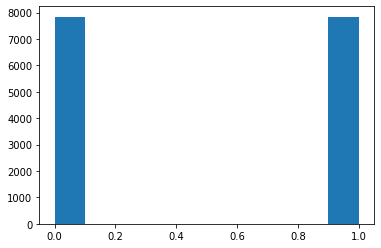

In [26]:
rus = RandomUnderSampler(random_state = 2020)
train_samples_rus, train_labels_rus = rus.fit_sample(train_samples, train_labels)

ros = RandomOverSampler(random_state = 2020)
train_samples_ros, train_labels_ros = ros.fit_sample(train_samples, train_labels)

smote_enn = SMOTEENN(random_state = 2020)
train_samples_smo, train_labels_smo = smote_enn.fit_sample(train_samples, train_labels)

plt.hist(train_labels_rus)

#plt.hist(train_labels_smo)

(array([24720.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 24720.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

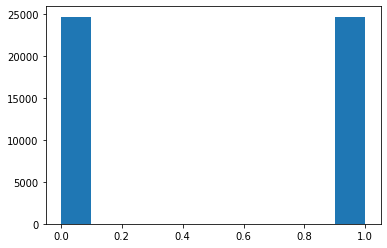

In [27]:
plt.hist(train_labels_ros)

(array([17332.,     0., 19171.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

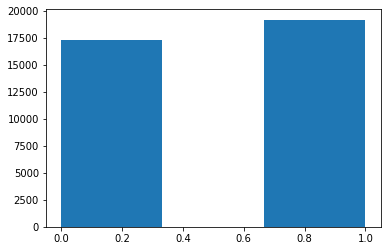

In [13]:
plt.hist(train_labels_smo, bins = 3)

In [28]:
from sklearn.metrics import matthews_corrcoef, make_scorer
def tune_pipe_KNN(x_train,y_train,plot=True):
    print('tuning pipe...') 
    matthews = make_scorer(matthews_corrcoef)
    
    n_neighbors_list = np.unique(np.round(np.geomspace(10, 500, 5)).astype(int))
    KNN = KNeighborsClassifier()
    
    tuned_parameters =  {"n_neighbors": n_neighbors_list
                        }
    stratified_kfold = StratifiedKFold(n_splits=5,random_state=2020, shuffle=True)
    
    CV = GridSearchCV(KNN, tuned_parameters,return_train_score=True,
                    cv=stratified_kfold,
                    scoring=matthews,
                    verbose=4)
    
    
    CV.fit(x_train, y_train)
    print(CV.best_params_)
    
    df = pd.DataFrame(
        (
            dict(n_neighbors=d["n_neighbors"], error=e, std=s)
            for d, e, s in zip(
                CV.cv_results_["params"],
                CV.cv_results_["mean_test_score"],
                CV.cv_results_["std_test_score"],
            )
        )
    )
    
    n = 4/5 * len(y_train)
    plt.errorbar(n/df["n_neighbors"], df["error"], yerr=df["std"])
    plt.xscale("log")
    plt.show()
    
    print('done')
    bestK = CV.best_params_['n_neighbors']
    KNN = KNeighborsClassifier(n_neighbors = CV.best_params_)
    return KNN

tuning pipe...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] n_neighbors=10 ..................................................
[CV] ......... n_neighbors=10, score=0.5181517325105476, total=  13.3s
[CV] n_neighbors=10 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.9s remaining:    0.0s


[CV] ......... n_neighbors=10, score=0.4933272909073896, total=  13.4s
[CV] n_neighbors=10 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] ......... n_neighbors=10, score=0.5068149621035604, total=  12.6s
[CV] n_neighbors=10 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV] ......... n_neighbors=10, score=0.5081218172062849, total=  12.2s
[CV] n_neighbors=10 ..................................................
[CV] ........ n_neighbors=10, score=0.48531509845494797, total=  13.1s
[CV] n_neighbors=27 ..................................................
[CV] ......... n_neighbors=27, score=0.5335435233214856, total=  13.4s
[CV] n_neighbors=27 ..................................................
[CV] ......... n_neighbors=27, score=0.5165313262636753, total=  13.1s
[CV] n_neighbors=27 ..................................................
[CV] ......... n_neighbors=27, score=0.5204533681835997, total=  13.2s
[CV] n_neighbors=27 ..................................................
[CV] ......... n_neighbors=27, score=0.5334505561946203, total=  13.9s
[CV] n_neighbors=27 ..................................................
[CV] ......... n_neighbors=27, score=0.5041669460737513, total=  14.3s
[CV] n_neighbors=71 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 28.6min finished


{'n_neighbors': 27}


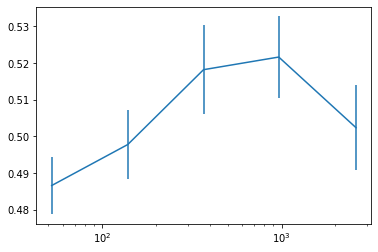

done


In [12]:
pipe = tune_pipe_KNN(train_samples,train_labels)

In [13]:
#print(len(train_samples[0]))
pipe = KNeighborsClassifier(n_neighbors = 71)
#pipe.fit(train_samples,train_labels)

In [31]:
import utils.analysing as AN
from sklearn.metrics import accuracy_score

def test(model,train_samples,train_labels,test_samples,test_labels):
    model.fit(train_samples,train_labels)
    pred = model.predict(test_samples)
    AN.plot_confusion_matrix(test_labels,pred)
    print(accuracy_score(test_labels,pred))


0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: Income, Length: 16281, dtype: int64
[0 0 1 ... 1 0 1]


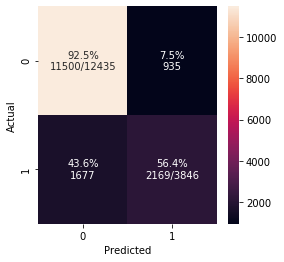

0.8395675941281248
0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: Income, Length: 16281, dtype: int64
[0 0 1 ... 1 0 1]


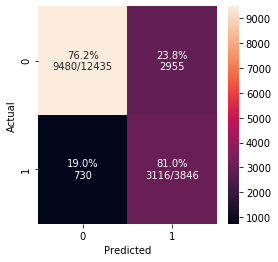

0.7736625514403292
0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: Income, Length: 16281, dtype: int64
[0 1 1 ... 1 0 1]


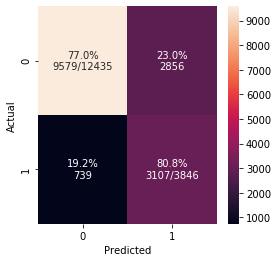

0.7791904674160064
0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: Income, Length: 16281, dtype: int64
[0 0 1 ... 1 0 1]


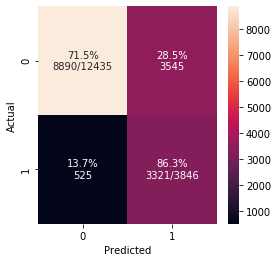

0.7500153553221547


In [32]:
test(pipe,train_samples,train_labels,test_samples,test_labels)
test(pipe,train_samples_rus,train_labels_rus,test_samples,test_labels)
test(pipe,train_samples_ros,train_labels_ros,test_samples,test_labels)
test(pipe,train_samples_smo,train_labels_smo,test_samples,test_labels)

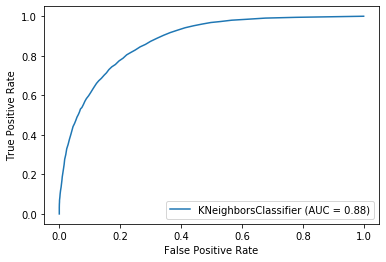

In [14]:
import sklearn
pipe.fit(train_samples,train_labels)
sklearn.metrics.plot_roc_curve(pipe,test_samples,test_labels)
#plt.plot(fpr,tpr,)

In [ ]:
pipe = KNeighborsClassifier(n_neighbors = 71)
pipe.fit(train_samples,train_labels)
sklearn.metrics.plot_roc_curve(pipe,test_samples,test_labels)
plt.plot(fpr,tpr,)

In [16]:
stratified_kfold = StratifiedKFold(n_splits=5,random_state=2020, shuffle=True)
cv_results = cross_validate(pipe,train_samples,train_labels,cv=stratified_kfold,scoring=None,return_train_score=True)

In [17]:
print(accuracy_score(test_labels,pred))

0.8395675941281248


In [18]:
print(cv_results)

{'fit_time': array([1.64781332, 1.65856528, 1.59525442, 1.82947326, 1.94280386]), 'score_time': array([12.65618014, 21.79586101, 13.02861261, 16.12374306, 19.58403444]), 'test_score': array([0.83832335, 0.83261671, 0.83476658, 0.83952703, 0.83046683]), 'train_score': array([0.84359644, 0.8462513 , 0.84506123, 0.84540673, 0.844447  ])}
